In [1]:
import huracanpy

## Loading IBTrACS
IBTrACS can be loaded in two ways using HuracanPy's `load` function:
* Online: You can load the latest version of any IBTrACS subset using the load function, provided you are connected to internet
* Offline: Your installation of huracanpy embeds parts of the IBTrACS database which can be loaded even if you are not connected to internet.


### Online
With the arguments `tracker = "ibtracs", ibtracs_online=True`, `load` will retrieve IBTrACS from the NCEI-NOAA (https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/). 
Use the `ibtracs_subset` argument to specify the subset you want to download. See the webpage mentionned above for the list of existing subset.

/Users/bourdin/Softs/huracanpy/huracanpy/_data/_csv.py:32: DtypeWarning: Columns (12,21,22,61,66) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks = pd.read_csv(filename, **read_csv_kws)


(<Figure size 720x720 with 1 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

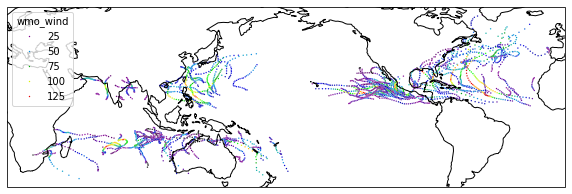

In [2]:
# Example of 'last3years' subset
ib = huracanpy.load(tracker = "ibtracs", ibtracs_online=True, ibtracs_subset = "last3years")
huracanpy.plot.plot_tracks_basic(ib, intensity_var="wmo_wind")

/Users/bourdin/Softs/huracanpy/huracanpy/_data/_csv.py:32: DtypeWarning: Columns (12,17,18,22,128,143) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks = pd.read_csv(filename, **read_csv_kws)


(<Figure size 720x720 with 1 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

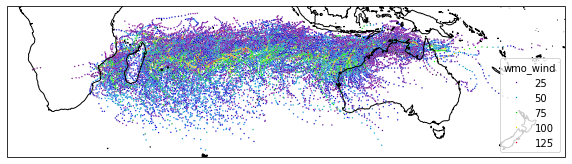

In [3]:
# Example of 'SI' subset
ib = huracanpy.load(tracker = "ibtracs", ibtracs_online=True, ibtracs_subset = "SI")
huracanpy.plot.plot_tracks_basic(ib, intensity_var="wmo_wind")

### Offline
Two subsets are currently available:
* "wmo" contains the data provided in the "wmo" columns, which correspond to the data provided by the center
      responsible for the area of a given point. (see https://community.wmo.int/en/tropical-cyclone-regional-bodies)
      Note that within this dataset, wind units are not homogeneous: they are provided as collected from the
      meteorological agencies, which means that they have different time-averaging for wind extrema. (default)
* "usa" contains the data provided in the "wmo" columns, which is provided by the NHC or the JTWC.

Loading these will raise a warning to remind you that these datasets are offline versions with caveats and some post-treatment.

/Users/bourdin/Softs/huracanpy/huracanpy/_data/ibtracs.py:90: UserWarning: This offline function loads a light version of IBTrACS which is embedded within the package, based on a file produced manually by the developers.
                  It was last updated on the 24nd May 2024, based on the IBTrACS file at that date.
                  It contains only data from 1980 up to the last year with no provisional tracks. All spur tracks were removed. Only 6-hourly time steps were kept.
  warnings.warn(
/Users/bourdin/Softs/huracanpy/huracanpy/_data/ibtracs.py:96: UserWarning: You are loading the IBTrACS-WMO subset.                       This dataset contains the positions and intensity reported by the WMO agency responsible for each basin
                      Be aware of the fact that wind and pressure data is provided as they are in IBTrACS,                       which means in particular that wind speeds are in knots and averaged over different time periods.
                    For more i

(<Figure size 720x720 with 1 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

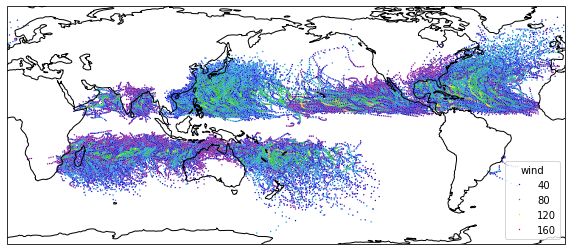

In [5]:
# WMO subset
ib_wmo = huracanpy.load(tracker = "ibtracs", ibtracs_online=False, ibtracs_subset = "wmo")
huracanpy.plot.plot_tracks_basic(ib_wmo, intensity_var="wind")

/Users/bourdin/Softs/huracanpy/huracanpy/_data/ibtracs.py:90: UserWarning: This offline function loads a light version of IBTrACS which is embedded within the package, based on a file produced manually by the developers.
                  It was last updated on the 24nd May 2024, based on the IBTrACS file at that date.
                  It contains only data from 1980 up to the last year with no provisional tracks. All spur tracks were removed. Only 6-hourly time steps were kept.
  warnings.warn(


(<Figure size 720x720 with 1 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

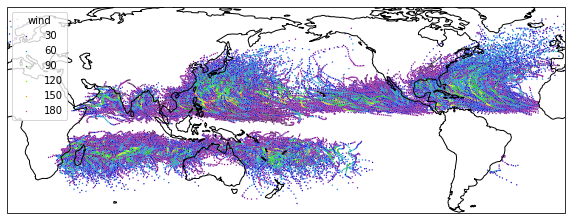

In [6]:
# USA subset
ib_usa = huracanpy.load(tracker = "ibtracs", ibtracs_online=False, ibtracs_subset = "usa")
huracanpy.plot.plot_tracks_basic(ib_usa, intensity_var="wind")

One of the main differences among these two subsets is the way winds are reported: In WMO, the maximum winds as reported by the WMO agencies are provided. This is inhomogeneous: the USA report 1-minute sustained winds, CMA reports 3-minutes sustained winds, and most other centers report 10-minutes sustained winds. 

In [7]:
# Add basin data to ib_wmo
ib_wmo["basin"] = huracanpy.utils.geography.get_basin(ib_wmo.lon, ib_wmo.lat)
# Match tracks between ib_wmo and ib_usa, then retrieve LMI
m = huracanpy.assess.match_pair(ib_wmo, ib_usa, "wmo", "usa")
max_winds = m.join(ib_wmo.groupby("track_id").max()[["wind", "basin"]].to_dataframe(), on = "id_wmo").join(ib_usa.groupby("track_id").max().wind.to_dataframe(), on = "id_usa", lsuffix = "_wmo", rsuffix = "_usa")

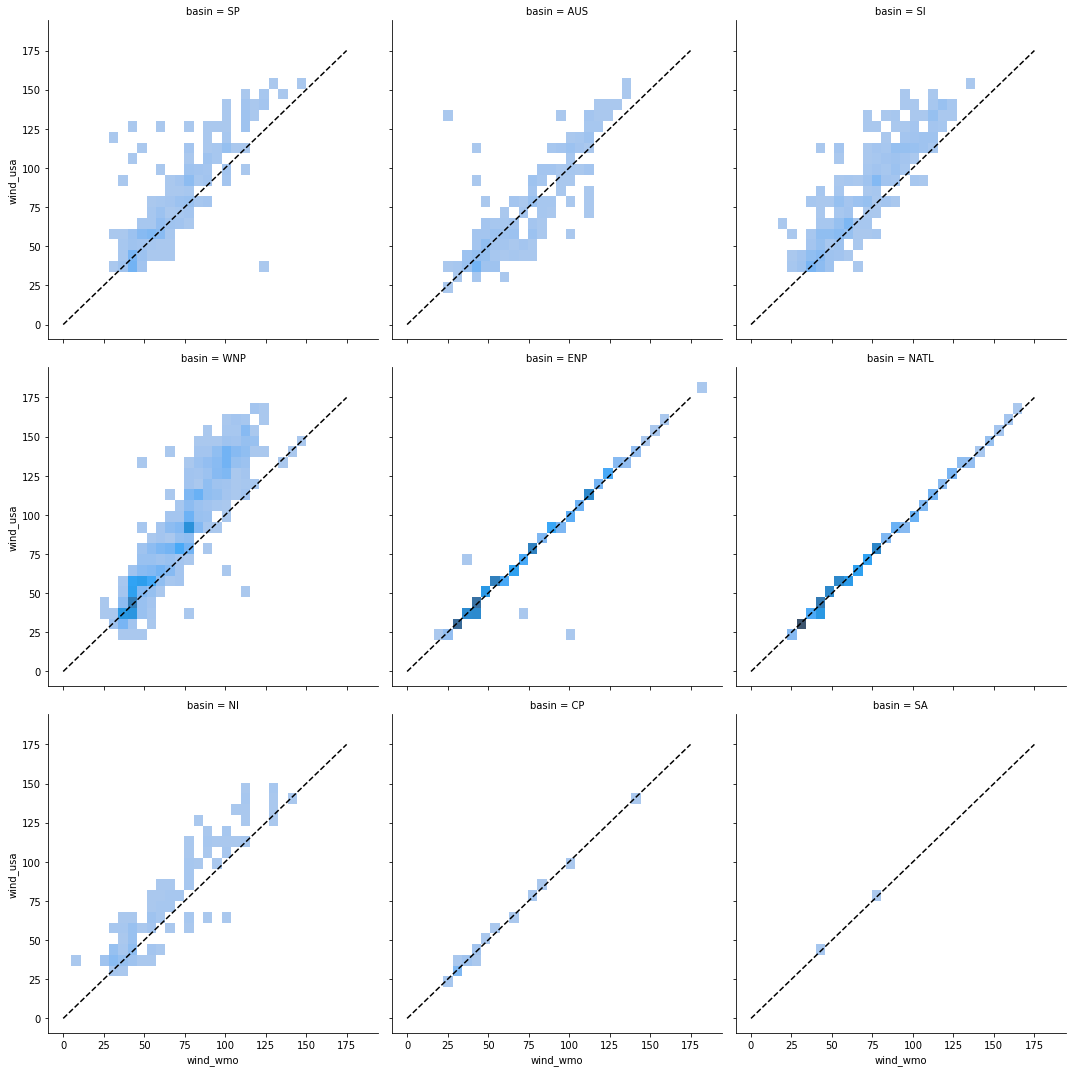

In [8]:
# Plot difference between WMO and USA winds in each basin
import seaborn as sns
p = sns.displot(data = max_winds, x = "wind_wmo", y = "wind_usa", col = "basin", col_wrap = 3,)
for ax in p.axes.flatten():
    ax.plot([0,175], [0,175], color = "k", linestyle = "--")